In [1]:
import importlib
from moma_analysis import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load Data
- Choose dataset

In [43]:
# load dataset
ds = 1
paths = {1:'data/191120_traces.csv', 2:'data/200114_traces_select_new.csv', 3:'data/200617_traces.csv'}
df = pd.read_csv(paths[ds])

fs = 6
t_cutoff = 50
if ds==3:
    t_cutoff = 35

# selection of traces
selection = df['id'].unique()  # all
# For now only use traces that look good right away, comment if wanted
#for val in [17, 20, 40, 53, 3]:
#    selection = selection[selection!=val]
# individual selection
#selection = [59,89]

# initialise features to be collected per trace
T = []
peaks = []
dec = []
rsq = []
intervals = []
av_g_intervals = []
phases = np.zeros((len(selection), fs*t_cutoff))

# loop over selection
for j, i in enumerate(selection):
    # calculate phases
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    cutoff_freq = 1/5
    s_lp = butter_lowpass_filter_noshift(s_interp, cutoff_freq, 6, order=2)
    window_length = 21
    #s_smooth = savgol_filter(s_interp, window_length, 3, mode='interp')
    s_smooth = savgol_filter(s_lp, window_length, 3, mode='interp')
    s_analytical = hilbert(s_smooth)
    #s_analytical = hilbert(s_lp)
    phases[j] = np.angle(s_analytical)

    
    # calculate decay
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_smooth = savgol_filter(s_interp, 31, 3)
    peaks_i, T_i = peak_locations(s_smooth, 6)
    dec_i, rsq_i, intervals_i = peak_decay(peaks_i, T_i, t_interp, s_interp, i)
    intervals.append(intervals_i)
    T.append(T_i)
    peaks.append(peaks_i)
    dec.append(dec_i)
    rsq.append(rsq_i)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
    else: 
        g_rate_switch = g_rate
    
    # calculate average growth rate in intervals of peak decay
    av_g_intervals_i = []
    for interval in intervals_i:
        indices = (6*interval).astype(int)
        av_g_intervals_i.append(np.mean(g_rate_switch[indices[0]:indices[1]]))
    av_g_intervals.append(av_g_intervals_i)

    
# ACF and xcorr

crosscorr_sum = np.zeros(fs*t_cutoff)
autocorr_growth_sum = np.zeros(fs*t_cutoff)
autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
    crosscorr_sum += crosscorr(s_interp, g_interp)

crosscorr_avg = crosscorr_sum/len(selection)
autocorr_avg = autocorr_sum/len(selection)
autocorr_growth_avg = autocorr_growth_sum/len(selection)


# collect features
av_g_intervals = np.concatenate(np.array(av_g_intervals))
# handle empty intervals
delete_empty_elements = []
intervals = np.array(intervals)
for i, interval in enumerate(intervals):
    if interval.shape==(0,):
        delete_empty_elements.append(i)
intervals = np.delete(intervals, delete_empty_elements)
intervals = np.concatenate(np.array(intervals))
Ti = T.copy()
T = np.concatenate(np.array(T))
dec = np.concatenate(np.array(dec))
rsq = np.concatenate(np.array(rsq))
uphases = np.unwrap(phases)
# does the following make sense?
phases0 = np.zeros_like(phases)
uphases0 = np.zeros_like(uphases)
for i in range(len(selection)):
    uphases0[i] = uphases[i]-uphases[i,0]
    phases0[i] = phases[i]-phases[i,0]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


No fit for id 3 peak 2
No fit for id 15 peak 0
No fit for id 18 peak 2


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


No fit for id 37 peak 2
No fit for id 39 peak 3
No fit for id 53 peak 2
No fit for id 81 peak 3
No fit for id 87 peak 3


# Figure 1
- ds=2
- seperate script for kymograph

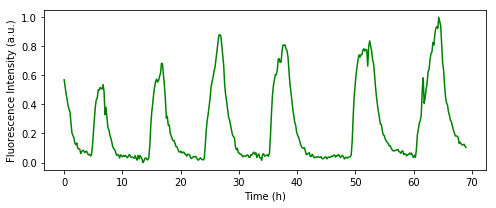

In [3]:
selection = df['id'].unique()
fs = 6
t_cutoff = 69
i = 6
name, t, sig = load_data(i, df)
t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
s_norm = (s_interp - s_interp.min())/(s_interp.max() - s_interp.min())

plt.figure(figsize=(7, 3))
plt.plot(t_interp, s_norm, 'g')
plt.xlabel('Time (h)')
plt.ylabel('Fluorescence Intensity (a.u.)')
plt.tight_layout()
#plt.savefig('figs/1d.pdf', dpi=400, transparent=True)

# Figure 2
- ds=1

10.9 +- 1.18e-03


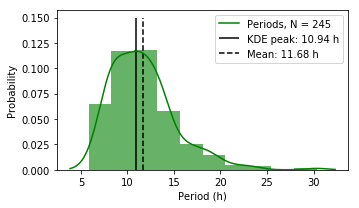

In [52]:
data = T
kernel = gaussian_kde(data)
Trange = np.linspace(np.min(data)-2, np.max(data)+2, 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')
p_index, p_err = peak_fit(kernel(Trange), kernel(Trange).argmax(), window=21)
kde_peak = interp_func(p_index)
kde_peak_err = p_err/fs_here
print(f'{kde_peak:.3} +- {kde_peak_err:.2e}')

l = "KDE peak: %.2f h" % kde_peak
l2 = "Mean: %.2f h" % np.mean(data)
l3 = "Periods, N = %i" % len(T)
plt.figure(figsize=(5, 3))
plt.title
n, b, p = plt.hist(data,  density=True, color='g', alpha=0.6)
plt.plot(Trange, kernel(Trange), color='g', label=l3)
plt.vlines(kde_peak, 0, 0.15, label=l, linestyles='solid')
plt.vlines(np.mean(data), 0, 0.15, label=l2, linestyles='dashed')
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Period (h)')
plt.tight_layout()
#plt.savefig('figs/2a.pdf', dpi=400, transparent=True)

In [103]:
# bootstrap error

data = T

Trange = np.linspace(np.min(data), np.max(data), 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')

def histogram_calc(data):
    kernel = gaussian_kde(data)
    p_index, p_err = peak_fit(kernel(Trange), kernel(Trange).argmax(), window=21)
    kde_peak = interp_func(p_index)
    #kde_peak_err = p_err/fs_here
    return kde_peak

out_hist = bootstrap(data, histogram_calc, 1000)

print(f'{np.mean(out_hist):.3} +- {np.std(out_hist):.3}')

10.6 +- 1.0


Decay 1.04 +- 1.03e-05
Growth 0.937 +- 1.13e-04
decay CV = 0.4044592692550117
growth CV = 0.2228376354770036


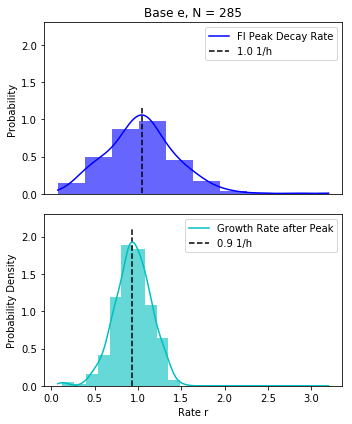

In [148]:
data1 = dec[dec<4] # base e
data2 = np.log(2)*av_g_intervals[dec<4] # base e

kernel1 = gaussian_kde(data1)
kernel2 = gaussian_kde(data2)
Trange = np.linspace(np.min([data1, data2]), np.max([data1, data2]), 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')

p_index1, p_err1 = peak_fit(kernel1(Trange), kernel1(Trange).argmax(), window=21)
kde_peak1 = interp_func(p_index1)
kde_peak_err1 = p_err1/fs_here
print(f'Decay {kde_peak1:.3} +- {kde_peak_err1:.2e}')

p_index2, p_err2 = peak_fit(kernel2(Trange), kernel2(Trange).argmax(), window=21)
kde_peak2 = interp_func(p_index2)
kde_peak_err2 = p_err2/fs_here
print(f'Growth {kde_peak2:.3} +- {kde_peak_err2:.2e}')

plt.figure(figsize=(5, 6))
plt.subplot(211)
plt.plot(Trange, kernel1(Trange), color='b', label='FI Peak Decay Rate')
plt.vlines(kde_peak1, np.min(kernel1(Trange)), 1.1*np.max(kernel1(Trange)), label = f'{kde_peak1:.1f} 1/h' ,linestyles='dashed')
n, b, p = plt.hist(data1,  density=True, color='b', alpha=0.6)
plt.legend()
plt.xticks([])
plt.ylim([0,2.3])
plt.ylabel('Probability')
plt.title(f'Base e, N = {len(data1)}')

plt.subplot(212)
plt.plot(Trange, kernel2(Trange), color='c', label='Growth Rate after Peak')
plt.vlines(kde_peak2, np.min(kernel2(Trange)), 1.1*np.max(kernel2(Trange)), label = f'{kde_peak2:.1f} 1/h' ,linestyles='dashed')
n, b, p = plt.hist(data2,  density=True, color='c', alpha=0.6)
plt.xlabel('Rate r')
plt.ylabel('Probability Density')
plt.ylim([0,2.3])
plt.legend()
plt.tight_layout()
plt.savefig('figs/2e.pdf', dpi=400, transparent=True)

print(f'decay CV = {np.std(data1)/np.mean(data1)}')
print(f'growth CV = {np.std(data2)/np.mean(data2)}')

In [106]:
# bootstrap error

data = dec[dec<4]

Trange = np.linspace(np.min(data), np.max(data), 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')

def histogram_calc(data):
    kernel = gaussian_kde(data)
    p_index, p_err = peak_fit(kernel(Trange), kernel(Trange).argmax(), window=21)
    kde_peak = interp_func(p_index)
    #kde_peak_err = p_err/fs_here
    return kde_peak

out_hist = bootstrap(data, histogram_calc, 1000)

print(f'dec: {np.mean(out_hist):.3} +- {np.std(out_hist):.3}')

data = np.log(2)*av_g_intervals[dec<4]

Trange = np.linspace(np.min(data), np.max(data), 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')

out_hist = bootstrap(data, histogram_calc, 1000)

print(f'grate: {np.mean(out_hist):.3} +- {np.std(out_hist):.3}')

dec: 1.04 +- 0.0332
grate: 0.942 +- 0.0292


11.8 +- 4.46e-03


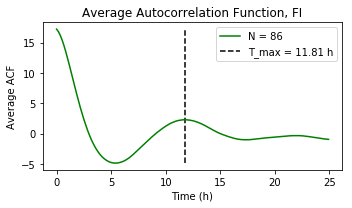

In [98]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
autocorr_avg = autocorr_sum/len(selection)
T_index, T_err = peak_fit(autocorr_avg[:150], autocorr_first_peak(autocorr_avg[:150]), window=21)
interp_func = interp1d(range(0, len(t_interp)), t_interp, fill_value='extrapolate', kind='cubic')
T_max = interp_func(T_index)
T_err = T_err/fs
print(f'{T_max:.3} +- {T_err:.2e}')

plt.figure(figsize=(5, 3))
plt.plot(t_interp[:150], autocorr_avg[:150], 'g-', label=f'N = {len(selection)}')
#plt.plot(t_interp, autocorr_growth_avg, label=f'growth, N = {len(selection)}')
#T_max = 1/freq_from_autocorr(autocorr_avg, 6)
plt.vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'T_max = {T_max:.2f} h', linestyles='dashed')
plt.ylabel('Average ACF')
plt.xlabel('Time (h)')
plt.title('Average Autocorrelation Function, FI')
plt.legend()
plt.tight_layout()
#plt.savefig('figs/2b.pdf', dpi=400, transparent=True)

In [101]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_arr = np.zeros((len(selection), fs*t_cutoff))
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_arr[j] = autocorr(s_interp)

interp_func = interp1d(range(0, len(t_interp)), t_interp, fill_value='extrapolate', kind='cubic')

def autocorr_calc(autocorr_arr):
    autocorr_avg = np.sum(autocorr_arr, axis=0)/autocorr_arr.shape[0]
    T_index, T_err = peak_fit(autocorr_avg[:150], autocorr_first_peak(autocorr_avg[:150]), window=21)
    T_max = interp_func(T_index)
    #Terr = T_err/fs
    return T_max
    
autocorr_calc(autocorr_arr)

out = bootstrap2(autocorr_arr, autocorr_calc, 1000)
print(f'{np.mean(out):.3} +- {np.std(out):.3}')

11.8 +- 0.357


# Figure 3
- ds=2

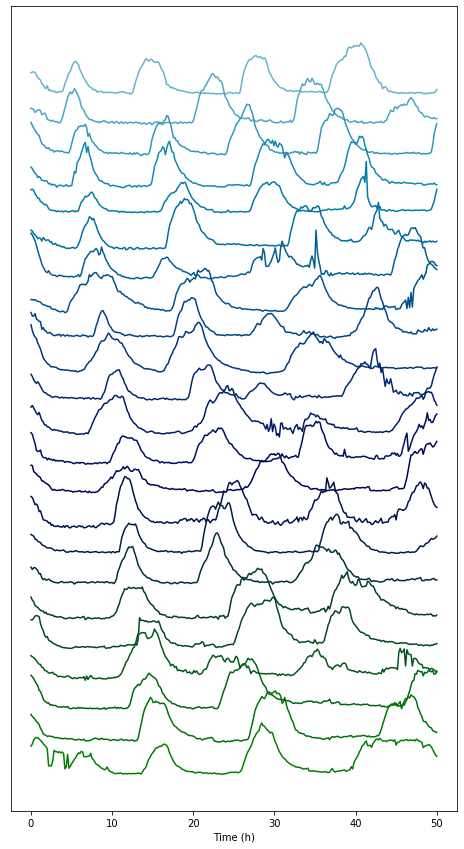

In [11]:
# 200114 selection waterfall plot
#df = pd.read_csv('../200114_proc/5_data/200114_traces_select_new.csv')
selection = df['id'].unique()
fs = 6
t_cutoff = 50


colors = [ cm.ocean(x) for x in np.linspace(0.8, 0, len(selection)) ]
offset = 0.6
h = 1 + len(selection)*offset
plt.figure(figsize=(8,h))

# sort selection by first peak
first_peak = np.zeros_like(selection)
for j, i in enumerate(selection):
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_smooth = savgol_filter(s_interp, 31, 3)
    peaks_i, T_i = peak_locations(s_smooth, 6)
    first_peak[j] = peaks_i[0]
sort_df = pd.DataFrame(data={'selection':selection, 'first_peak':first_peak})
sorted_selection = sort_df.sort_values(by=['first_peak'])['selection'].values

for j, i in enumerate(sorted_selection):
    # calculate phases
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_offset = s_interp - j*offset
    plt.plot(t_interp, s_offset, color=colors[j])
    plt.xlabel('Time (h)')
    plt.yticks([], [])
    #plt.plot(t_interp, s_offset, color='k')

plt.savefig('figs/3a.pdf', dpi=400, transparent=True)

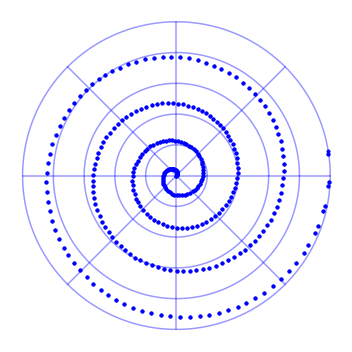

In [4]:
plt.figure(figsize=(5,5))
stop = -1
angles = np.mean(uphases, axis=0)[:stop]
t = np.array(range(len(angles)))/(len(angles))

line = np.linspace(-1, 1, 100)

# grid
plt.plot([0,0], [-1,1], 'b-', alpha=0.4)
plt.plot([-1,1], [0,0], 'b-', alpha=0.4)
plt.plot([-0.5*np.sqrt(2),0.5*np.sqrt(2)], [-0.5*np.sqrt(2),0.5*np.sqrt(2)], 'b-', alpha=0.4)
plt.plot([-0.5*np.sqrt(2),0.5*np.sqrt(2)], [0.5*np.sqrt(2),-0.5*np.sqrt(2)], 'b-', alpha=0.4)
for tick in np.linspace(0,1,6):
    plt.plot(tick*np.cos(np.linspace(0, 2*np.pi, 500)), tick*np.sin(np.linspace(0, 2*np.pi, 500)), 'b-', alpha=0.4)

for i in range(len(angles)):
    if i==0:
        x = [0, t[i]*np.cos(angles[i])]
        y = [0, t[i]*np.sin(angles[i])]
    else:
        x = [t[i-1]*np.cos(angles[i-1]), t[i]*np.cos(angles[i])]
        y = [t[i-1]*np.sin(angles[i-1]), t[i]*np.sin(angles[i])]
        
    #plt.plot(t[i]*np.cos(angles[i] + line*std[i]), t[i]*np.sin(angles[i] + line*std[i]), 'c-')    
    plt.plot(x, y, 'b.', alpha=1)
    cond = np.abs([np.cos(angles[i]), np.sin(angles[i])])
    #if (cond[0]+cond[1])<1.03:
    #if (i%40)==0:
    #    cond = np.abs([np.cos(angles[i]), np.sin(angles[i])])
    #    plt.plot(t[i]*np.cos(angles[i]), t[i]*np.sin(angles[i]), 'bo')
    #    plt.plot(t[i]*np.cos(angles[i] + line*std[i]), t[i]*np.sin(angles[i] + line*std[i]), 'c-')

plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
#plt.savefig('figs/3b1.pdf', dpi=400, transparent=True)

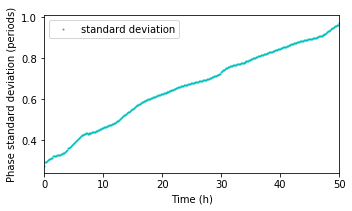

In [6]:
plt.figure(figsize=(5, 3))

plt.plot(t_interp, np.std(uphases, axis=0)/(2*np.pi), 'c.', ms=2, label='standard deviation')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Phase standard deviation (periods)')
plt.xlim([0, 50])

plt.tight_layout()
#plt.savefig('figs/3c1.pdf', dpi=400, transparent=True)

# Growth rate plots

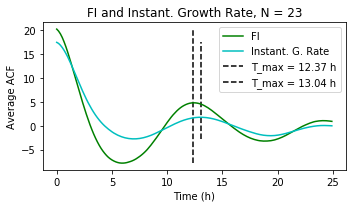

In [20]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_growth_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
autocorr_growth_avg = autocorr_growth_sum/len(selection)

T_max_g = t_g_interp[int(autocorr_first_peak(autocorr_growth_avg[:150]))]
T_max = t_interp[int(autocorr_first_peak(autocorr_avg[:150]))]

plt.figure(figsize=(5, 3))
plt.plot(t_interp[:150], autocorr_avg[:150], 'g-', label='FI')
plt.plot(t_g_interp[:150], autocorr_growth_avg[:150], 'c-', label='Instant. G. Rate')
plt.vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'T_max = {T_max:.2f} h', linestyles='dashed')
plt.vlines(T_max_g, ymin=np.min(autocorr_growth_avg), ymax=np.max(autocorr_growth_avg), label=f'T_max = {T_max_g:.2f} h', linestyles='dashed')
plt.legend()
plt.ylabel('Average ACF')
plt.title(f'FI and Instant. Growth Rate, N = {len(selection)}')
plt.xlabel('Time (h)')
plt.tight_layout()
plt.savefig('figs/3d.pdf', dpi=400, transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


NameError: name 'crosscorr_ctrl' is not defined

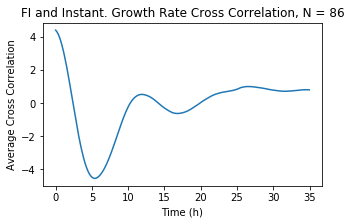

In [27]:
# cross correlation between FI and growth
selection = df['id'].unique()
fs = 6
t_cutoff = 50

crosscorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)

    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    
    crosscorr_sum += crosscorr(s_interp, g_interp)
crosscorr_avg = crosscorr_sum/len(selection)

#crosscorr_ctrl = crosscorr_avg # run with ds=3

plt.figure(figsize=(5, 3))
plt.ylabel('Average Cross Correlation')
plt.xlabel('Time (h)')
plt.title(f'FI and Instant. Growth Rate Cross Correlation, N = {len(selection)}')
plt.plot(t_interp[:210], crosscorr_avg[:210], label='Oscillating')
plt.plot(t_interp[:210], crosscorr_ctrl[:210], label='Control')
T_max = t_interp[int(autocorr_first_peak(crosscorr_avg[:150]))]
plt.vlines(T_max, ymin=np.min(crosscorr_avg), ymax=np.max(crosscorr_avg), label=f'T_max = {T_max:.2f} h', linestyles='dashed')
plt.legend()
plt.tight_layout()
#plt.savefig('figs/3e.pdf', dpi=400, transparent=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Growth rate: 1.300 +- 0.449


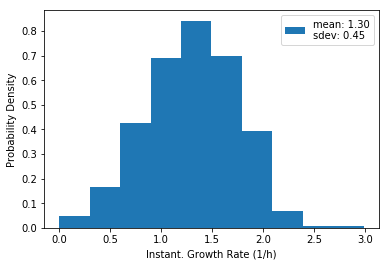

In [51]:
# histograms of g_rate values
selection = df['id'].unique()
fs = 6
t_cutoff = 50

g_rate_values = np.zeros((len(selection),fs*t_cutoff))
for j, i in enumerate(selection):
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)

    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp_nonorm(g_rate_switch, t_switch, t_cutoff, fs)
    g_rate_values[j,:] = g_interp

g_rate_values = g_rate_values[g_rate_values>0]
g_rate_values = g_rate_values[g_rate_values<3]


m = np.mean(g_rate_values.flatten())
s = np.std(g_rate_values.flatten())
a,b,c = plt.hist(g_rate_values.flatten(), density=True, label=f'mean: {m:.2f}\nsdev: {s:.2f}')
plt.legend()
plt.xlabel('Instant. Growth Rate (1/h)')
plt.ylabel('Probability Density')
print(f'Growth rate: {m:.3f} +- {s:.3f}')

#plt.savefig(f'../figures/supp/{ds}gratehist.png', dpi=600)
#plt.savefig(f'../figures/supp/{ds}gratehist.pdf', transparent=True)

In [54]:
data = T
kernel = gaussian_kde(data)
Trange = np.linspace(np.min(data)-2, np.max(data)+2, 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')
p_index, p_err = peak_fit(kernel(Trange), kernel(Trange).argmax(), window=21)
kde_peak = interp_func(p_index)
print(f'{kde_peak*m} generations most likely period')

14.216111862950596 generations most likely period


# Info theory figs

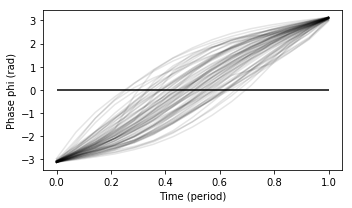

In [17]:
complete_periods = []
for i in range(phases.shape[0]):
    dp = np.diff(phases[i])
    periods = np.where(dp<-6)[0]
    prev = periods[0] + 1
    for p in periods[1:]:
        if (p+1-prev) > 10: # catch outlier
            complete_periods.append(phases[i][prev:p+1])
        prev = p + 1
        
from scipy.interpolate import interp1d
N = 15
sampling = np.linspace(0,1,N)

period_arr = np.zeros((len(complete_periods), N))
for j in range(len(complete_periods)):
    t = np.linspace(0,1,len(complete_periods[j]))
    interp_func = interp1d(t, complete_periods[j], fill_value='extrapolate', kind='cubic')
    period_arr[j] = interp_func(sampling)

plt.figure(figsize=(5, 3))
for i in range(period_arr.shape[0]):
    plt.plot(sampling, period_arr[i], 'k', alpha=0.1)
#plt.errorbar(x = sampling, y = np.mean(period_arr, axis=0), yerr = np.std(period_arr, axis=0), fmt='none', ecolor='k', capsize=3)
plt.hlines(0, xmin=0, xmax=1)
plt.xlabel('Time (period)')
plt.ylabel('Phase phi (rad)')
plt.tight_layout()
plt.savefig('figs/4a.pdf', dpi=400, transparent=True)

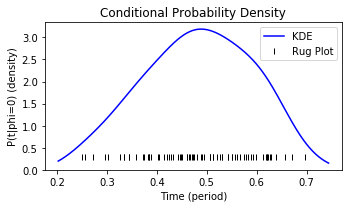

In [24]:
# cond. prob. dist.
# what time does the curve hit a given value phi* -> invert interpolation function

cond = []
phase_ = 0
for i in range(period_arr.shape[0]):
    cond.append(np.interp(phase_, period_arr[i], sampling))
cond = np.array(cond)

plt.figure(figsize=(5, 3))
#a, b, c = plt.hist(cond)
data = cond
kernel = gaussian_kde(data)
Trange = np.linspace(np.min(data) - 0.1*np.mean(data), np.max(data) + 0.1*np.mean(data), 1000)
plt.plot(Trange, kernel(Trange), color='b', label='KDE')
plt.plot(data,0.3*np.ones_like(data), '|', color='k', label='Rug Plot')
plt.legend()

plt.xlabel('Time (period)')
plt.ylabel('P(t|phi=0) (density)')
plt.title('Conditional Probability Density')
plt.tight_layout()
plt.savefig('figs/4a_inset.pdf', dpi=400, transparent=True)
## rug plot!

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


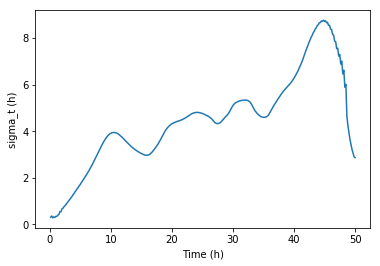

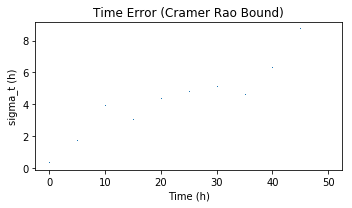

In [35]:
def fisher(mean, std, d_mean, d_std):
    #if len(mean) != len(d_mean):
        #raise ValueError('Check equal vector length')
    return (d_mean**2/std**2 + 2*d_std**2/std**2)

def cramer_rao(f):
    return np.sqrt(1/f)

p_mean = np.mean(uphases, axis=0)/(2*np.pi)
p_std = np.std(uphases, axis=0)/(2*np.pi)
t_ = t_interp
d_p_mean = savgol_filter(np.diff(p_mean), 17, 1)
d_p_std = savgol_filter(np.diff(p_std), 17, 1)

sigma = 1/np.sqrt(fisher(p_mean[1:], p_std[1:], d_p_mean, d_p_std))/fs
plt.figure()
plt.plot(t_[1:], sigma)
plt.ylabel('sigma_t (h)')
plt.xlabel('Time (h)')


plt.figure(figsize=(5, 3))
sigma_interp = np.interp(np.arange(0,50,5), t_[1:], sigma)
plt.plot(np.arange(0,50,5), sigma_interp, ',')
plt.plot(t_interp, 5*np.ones_like(t_interp), 'k', alpha=0) # for matching x axis
plt.title('Time Error (Cramer Rao Bound)')
plt.ylabel('sigma_t (h)')
plt.xlabel('Time (h)')
plt.tight_layout()
plt.savefig('figs/4b_inset.pdf', dpi=400, transparent=True)

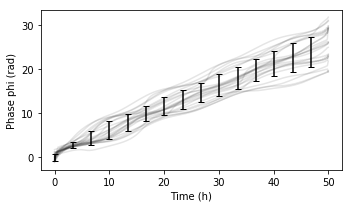

In [123]:
plt.figure(figsize=(5, 3))
for i in range(uphases.shape[0]):
    plt.plot(t_interp, uphases[i], 'k', alpha=0.1)
plt.errorbar(t_interp[::20], p_mean[::20]*2*np.pi, yerr=p_std[::20]*2*np.pi, fmt='none', ecolor='k', capsize=3)
plt.xlabel('Time (h)')
plt.ylabel('Phase phi (rad)')
plt.tight_layout()
#plt.savefig('figs/4b.pdf', dpi=400, transparent=True)

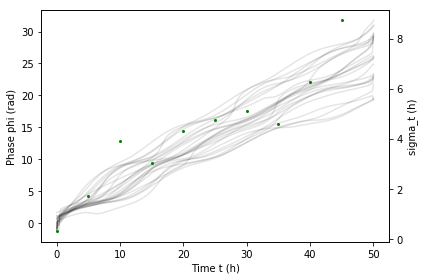

In [139]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
for i in range(uphases.shape[0]):
    ax1.plot(t_interp, uphases[i], 'k', alpha=0.1)
#ax1.errorbar(t_interp[::20], p_mean[::20]*2*np.pi, yerr=p_std[::20]*2*np.pi, fmt='none', ecolor='k', capsize=3)
ax2.plot(np.arange(0,50,5), sigma_interp, 'go', markersize=2)

ax1.set_xlabel('Time t (h)')
ax1.set_ylabel('Phase phi (rad)')
ax2.set_ylabel('sigma_t (h)')

plt.tight_layout()
plt.savefig('figs/4combo.pdf', dpi=400, transparent=True)

## Fit Gaussian to ACF

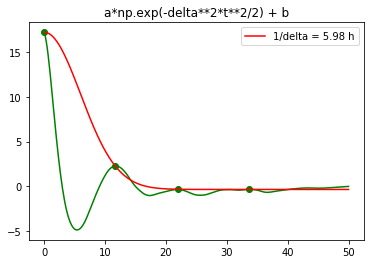

In [92]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
autocorr_avg = autocorr_sum/len(selection)


plt.plot(t_interp[:], autocorr_avg[:], 'g-')
peaks, _ = find_peaks(autocorr_avg, prominence=0.15, distance=20)
peaks = np.append(0, peaks)
plt.plot(peaks/fs, autocorr_avg[peaks], 'go')

from scipy.optimize import curve_fit
def fitfunc(t, delta, a, b):
    return (a*np.exp(-delta**2*(t)**2/2) + b)

p0 = [0.16, 17.4, -0.3]
popt, pcov = curve_fit(fitfunc, peaks/fs, autocorr_avg[peaks], p0, maxfev=100000)

x_range = np.linspace(0, 50, 1000)
plt.plot(x_range, fitfunc(x_range, *popt), 'r-', label=f'1/delta = {1/popt[0]:.3} h')
plt.title('a*np.exp(-delta**2*t**2/2) + b')
plt.legend()

plt.savefig('figs/acf_fit.png', dpi=500)

## Sim Plot

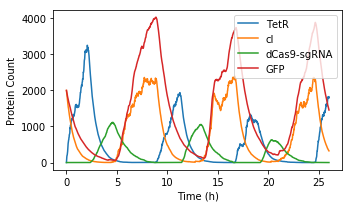

In [149]:
df = pd.read_csv('data/sim_data_for_paper.csv')
t = df['Time'].values
ci = df['cI'].values
tetr = df['TetR'].values
crispri = df['dCas9-sgRNA'].values
gfp = df['GFP'].values
cond = (t/3600) <= 26

plt.figure(figsize=(5, 3))
plt.plot(t[cond]/3600, tetr[cond], label='TetR')
plt.plot(t[cond]/3600, ci[cond], label='cI')
plt.plot(t[cond]/3600, crispri[cond], label='dCas9-sgRNA')
plt.plot(t[cond]/3600, gfp[cond], label='GFP')
plt.xlabel('Time t (h)')
plt.ylabel('Protein Count')
plt.legend()

plt.tight_layout()
plt.savefig('figs/2d.pdf', dpi=400, transparent=True)